Note: you may need to restart the kernel to use updated packages.


In [54]:
#Data Preprocessing 
import pandas as pd 
import numpy as np 


import sklearn


#Regression model
import xgboost as xgb 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

#Model Making and Evaluation
from sklearn import metrics
from sklearn.metrics import r2_score,mean_absolute_error

from datetime import datetime
import nltk
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from sklearn.ensemble import RandomForestClassifier
from bs4 import BeautifulSoup             
import re

#visualization
import matplotlib.pyplot as plt 
from wordcloud import WordCloud
import seaborn as sns 


# Filter all warnings
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yhite\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [55]:
data=pd.read_parquet('cleaned_file.parquet').drop(columns = ['reviews_per_mnth'], axis = 1)

In [56]:
## Removing outliers in price 


#Method-1
#temp=data.price.quantile([0.25,0.75])
#temp['low']=temp[0.25]-1.5*(temp[0.75]-temp[0.25])
#temp['high']=temp[0.75]+1.5*(temp[0.75]-temp[0.25])

#Method-2
#Filtering out based on the cap
## since low is less than 0 so capping to 30 as price can't be negative and less than 30 in worst case scenario
#temp['low']=0
#print (temp)





data.room_type = data.room_type.astype(str)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10450 entries, 0 to 10449
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   name                            10450 non-null  object        
 1   host_id                         10450 non-null  int64         
 2   neighbourhood                   10450 non-null  int64         
 3   latitude                        10450 non-null  float64       
 4   longitude                       10450 non-null  float64       
 5   room_type                       10450 non-null  object        
 6   price                           10450 non-null  int64         
 7   minimum_nights                  10450 non-null  int64         
 8   number_of_reviews               10450 non-null  int64         
 9   last_review                     7643 non-null   datetime64[ns]
 10  reviews_per_month               7643 non-null   float64       
 11  ca

In [57]:
data.head()

,name,host_id,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,Zen-East in the Heart of Austin (monthly rental),2466,78702,30.27750,-97.71398,Entire home/apt,179,7,24,2019-03-16,0.17,3,125
1,"Eco friendly, Colorful, Clean, Cozy monthly share",2466,78702,30.27577,-97.71379,Private room,114,30,9,2018-03-14,0.06,3,0
2,"Walk to 6th, Rainey St and Convention Ctr",8028,78702,30.26112,-97.73448,Entire home/apt,111,2,537,2020-10-25,3.78,1,355
3,"Soco, Barton Springs Private Guest Cottage",7148,78704,30.24630,-97.76361,Entire home/apt,46,30,20,2012-05-24,0.14,2,47
4,NW Austin Room,8186,78729,30.45697,-97.78422,Private room,39,1,258,2020-11-02,2.00,1,26


In [58]:
#data=data[(data['price']>30) & (data['price']<=505)]
data=data[~(data['neighbourhood']==78712)]
#----



X=data.drop(['price'],axis=1)
y=data[['price']]


In [59]:
## splitting training and test data
from sklearn.model_selection import train_test_split


# Assuming your features are stored in X and the corresponding labels in y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [60]:
## If I try to use mean of train_dataset and use it as prediction here for test dataset and  calculating r2_score

## Ideally our predictions should be better than the mean. Because if it is not , guessing the numbers is better. 
y_avg=y_train.mean()
y_predict=[y_avg.price]*2090
print (mean_absolute_error(y_test['price'].tolist(),y_predict))

## Negative R2 means the average is even worse than the horizontal line

227.5346364998838


In [61]:
## Data Analysis 
#print(data.id.nunique())
print (data.name.nunique())
print (data.host_id.nunique())
print (data.neighbourhood.nunique())
print (data.latitude.nunique())
print (data.longitude.nunique())


9724
6805
43
7309
6965


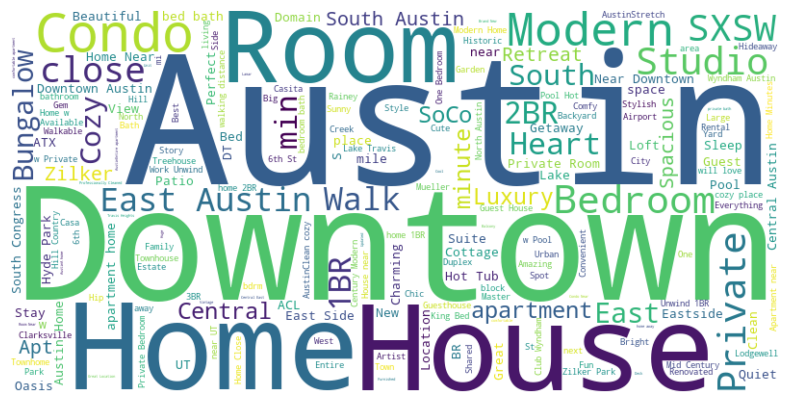

In [62]:
text_corpus = ''.join(data['name'])
#print(text_corpus)


# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_corpus)
print(wordcloud)
# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [63]:
## This tells us about neighbourhood

temp=data.groupby(['neighbourhood','room_type']).agg({'price':'mean'}).reset_index().sort_values(by='price',ascending=False)
temp.dropna(inplace=True)

temp


,neighbourhood,room_type,price
51,78733,Hotel room,2500.000000
48,78732,Entire home/apt,1160.622222
50,78733,Entire home/apt,1142.030303
76,78746,Entire home/apt,903.786408
77,78746,Hotel room,875.000000
...,...,...,...
114,78759,Shared room,25.000000
94,78751,Shared room,23.684211
108,78757,Shared room,20.000000
105,78756,Shared room,18.100000


['Hotel room', 'Entire home/apt', 'Private room', 'Shared room']


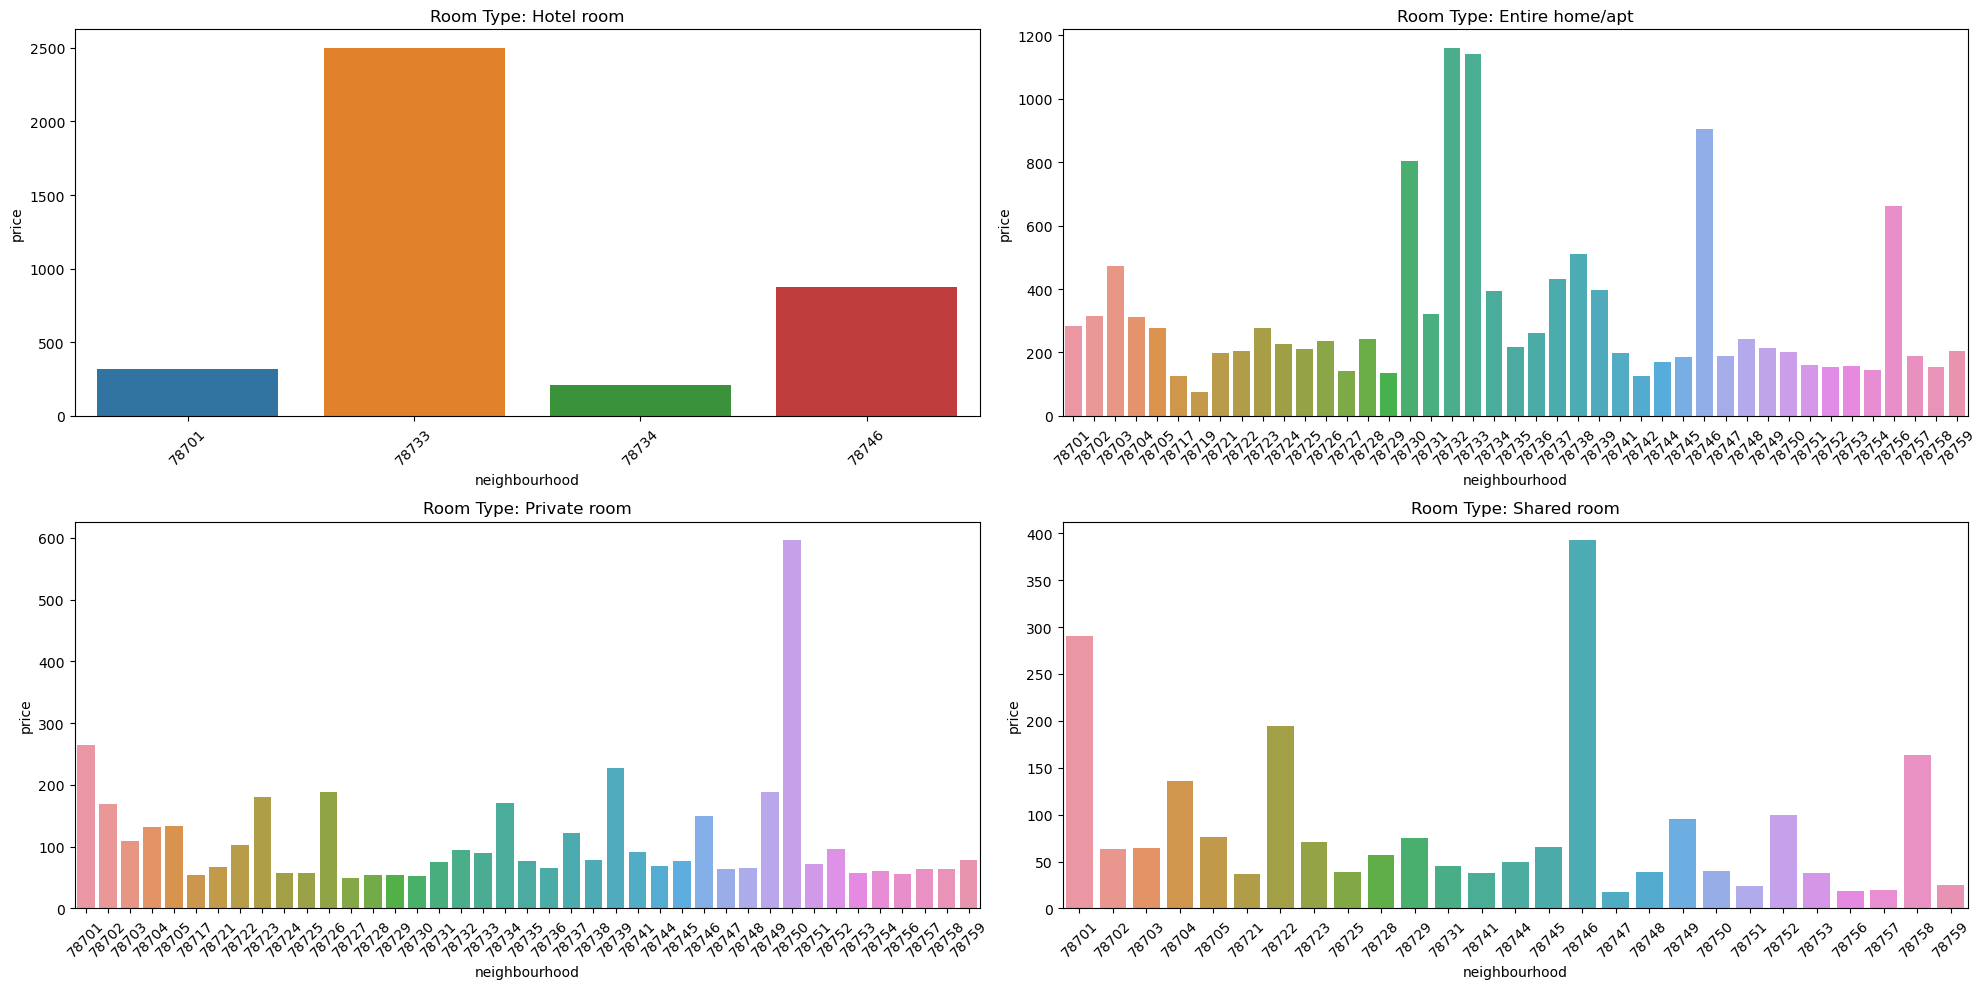

In [64]:
# Create the subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
unique_room_types = temp.room_type.unique().tolist()
print(unique_room_types)
# Iterate over each room type and plot on the corresponding subplot
for i, room_type in enumerate(unique_room_types):
    row = i // 2  # Calculate the row index
    col = i % 2  # Calculate the column index

    ax = axes[row, col]  # Get the corresponding axis

    sns.barplot(data=temp[temp['room_type'] == room_type], x='neighbourhood', y='price', ax=ax)
    ax.set_title(f'Room Type: {room_type}')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)  # Rotate x-axis labels

# Adjust the spacing between subplots
plt.tight_layout()

# Display the subplots
plt.show()

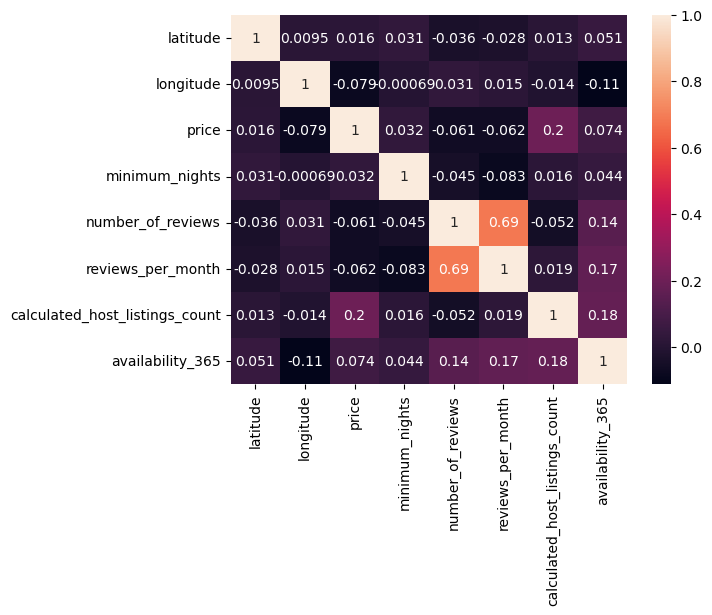

In [65]:
numeric_datatypes = data.select_dtypes(exclude=['object','category'])
numeric_datatypes['reviews_per_month'].fillna(0, inplace=True)
numeric_datatypes['year']=pd.to_datetime(numeric_datatypes.last_review.dt.year)
numeric_datatypes.drop(columns=['host_id','neighbourhood','last_review'],inplace=True)
numeric_datatypes.dropna(subset=['year'],inplace=True)

## Nothing is negative correlated
## explain what correlation is here

## High correlation (positive or negative kindof tells us that target variable could be affected significantly by that variable)

temp =  numeric_datatypes.corr()
#print(temp)
sns.heatmap(temp, annot = True)
# annot = true
plt.show()

In [66]:
## removing last_review as it does not tell us good information
## removing ID because it is the primary key and is unique which differenciates among all records
## removing reviews_per_month as it is highly correlated with number of reviews. 

In [67]:
def data_cleaning_and_processing(frame,word='not'):
    ## removing latitude and longitude because AIRBNB will not give us the exact location of a particular host.
    frame=frame.drop(['last_review','reviews_per_month','latitude','longitude'],axis=1)
    ## we are not doing text processing right now so name will remove it 
    if (word=='not'):
        frame=frame.drop(['name'],axis=1)
    ## It has around 6000 unique host_id and we don't want to make high dimentional data as it could introduce noise sometimes. 
    frame=frame.drop(['host_id'],axis=1)
    ## dummy encoding of our features
   
    dummy_encoded = pd.get_dummies(frame, columns=['neighbourhood', 'room_type'], prefix=['neighbourhood', 'room_type'], dtype = int) 
    print(dummy_encoded)                            
    return dummy_encoded


    

In [68]:
train_df=data_cleaning_and_processing(X_train)
test_df=data_cleaning_and_processing(X_test)

      minimum_nights  number_of_reviews  calculated_host_listings_count  \
2924               2                 93                              13   
6649               1                  1                               1   
2524               2                 15                              17   
8402               2                 14                              32   
5241               2                 25                               3   
...              ...                ...                             ...   
5736               1                  1                               1   
5193              29                  3                              81   
5392              31                  5                               1   
861                1                133                              38   
7272               2                 32                               1   

      availability_365  neighbourhood_78701  neighbourhood_78702  \
2924                73         

In [69]:
print (train_df.shape)
print (test_df.shape)

(8358, 51)
(2090, 51)


In [70]:
test_df.head()

,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,neighbourhood_78701,neighbourhood_78702,neighbourhood_78703,neighbourhood_78704,neighbourhood_78705,neighbourhood_78717,...,neighbourhood_78753,neighbourhood_78754,neighbourhood_78756,neighbourhood_78757,neighbourhood_78758,neighbourhood_78759,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room
5428,1,30,3,343,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
673,3,7,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
5230,2,19,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
5947,1,15,1,276,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1218,2,274,2,304,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [71]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8358 entries, 2924 to 7272
Data columns (total 51 columns):
 #   Column                          Non-Null Count  Dtype
---  ------                          --------------  -----
 0   minimum_nights                  8358 non-null   int64
 1   number_of_reviews               8358 non-null   int64
 2   calculated_host_listings_count  8358 non-null   int64
 3   availability_365                8358 non-null   int64
 4   neighbourhood_78701             8358 non-null   int32
 5   neighbourhood_78702             8358 non-null   int32
 6   neighbourhood_78703             8358 non-null   int32
 7   neighbourhood_78704             8358 non-null   int32
 8   neighbourhood_78705             8358 non-null   int32
 9   neighbourhood_78717             8358 non-null   int32
 10  neighbourhood_78719             8358 non-null   int32
 11  neighbourhood_78721             8358 non-null   int32
 12  neighbourhood_78722             8358 non-null   int32
 13  

In [72]:
train_df=data_cleaning_and_processing(X_train)
test_df=data_cleaning_and_processing(X_test)

      minimum_nights  number_of_reviews  calculated_host_listings_count  \
2924               2                 93                              13   
6649               1                  1                               1   
2524               2                 15                              17   
8402               2                 14                              32   
5241               2                 25                               3   
...              ...                ...                             ...   
5736               1                  1                               1   
5193              29                  3                              81   
5392              31                  5                               1   
861                1                133                              38   
7272               2                 32                               1   

      availability_365  neighbourhood_78701  neighbourhood_78702  \
2924                73         

In [73]:
## Simple Regression Modelling
import statsmodels.api as sm
import numpy as np




model = sm.OLS(y_train,train_df)
model = model.fit()


In [74]:
model.summary()

#from sklearn.metrics import make_scorer, r2_score


# r^2 : [0:1] -> Tells about the residulas/errors
#adjusted r^2: [-infinity:1] -> this tells how about model's complexity based on the # of predictors
# adjusted r^2 is a better metric

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     14.94
Date:                Thu, 20 Jun 2024   Prob (F-statistic):          1.06e-116
Time:                        12:46:10   Log-Likelihood:                -65335.
No. Observations:                8358   AIC:                         1.308e+05
Df Residuals:                    8308   BIC:                         1.311e+05
Df Model:                          49                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
minimum_nights                     0.9254      0.272      3.401      0.001       0.392       1.459
number_of_reviews                 -0.8903      0.103     -8.624      0.000      -1.093      -0.688
calculated_host_listings_count    -0.3216      0.055     -5.818      0.000      -0.430      -0.213
availability_365                   0.2216      0.051      4.335      0.000       0.121       0.322
neighbourhood_78701                6.1581     28.470      0.216      0.829     -49.650      61.966
neighbourhood_78702               46.6813     24.024      1.943      0.052      -0.411      93.774
neighbourhood_78703              177.6718     33.001      5.384      0.000     112.982     242.361
neighbourhood_78704               11.0578     21.984      0.503      0.615     -32.037      54.152
neighbourhood_78705              -10.4696     34.967     -0.299      0.765     -79.014      58.075
neighbourhood_78717             -130.4631     75.912     -1.719      0.086    -279.270      18.344
neighbourhood_78719             -273.7243    264.202     -1.036      0.300    -791.626     244.178
neighbourhood_78721              -81.1906     48.168     -1.686      0.092    -175.612      13.230
neighbourhood_78722              -67.4610     47.177     -1.430      0.153    -159.939      25.017
neighbourhood_78723               19.4415     40.304      0.482      0.630     -59.565      98.448
neighbourhood_78724              -90.9422     94.541     -0.962      0.336    -276.266      94.382
neighbourhood_78725              -70.4952     98.437     -0.716      0.474    -263.456     122.465
neighbourhood_78726              -66.4481    197.176     -0.337      0.736    -452.962     320.065
neighbourhood_78727             -126.2309     64.004     -1.972      0.049    -251.695      -0.767
neighbourhood_78728              -97.8009     81.154     -1.205      0.228    -256.884      61.282
neighbourhood_78729              -96.4902     59.024     -1.635      0.102    -212.192      19.211
neighbourhood_78730              339.2297    124.137      2.733      0.006      95.891     582.569
neighbourhood_78731                2.1952     62.185      0.035      0.972    -119.703     124.093
neighbourhood_78732              621.7331     90.317      6.884      0.000     444.689     798.777
neighbourhood_78733              801.1222     74.266     10.787      0.000     655.543     946.701
neighbourhood_78734               83.2744     45.769      1.819      0.069      -6.445     172.994
neighbourhood_78735              -67.3564     63.599     -1.059      0.290    -192.026      57.313
neighbourhood_78736              -55.2531    107.129     -0.516      0.606    -265.253     154.747
neighbourhood_78737              153.9826     70.070      2.198      0.028      16.628     291.337
neighbourhood_

In [75]:
y_predict=model.predict(test_df)


#y_predict.sort_values(by = 'price')
r2_score(y_test,y_predict)

0.09555595279330398

In [76]:
y_predict = pd.DataFrame(y_predict)

In [77]:
y_predict.rename(columns = {0: 'price'}, inplace = True)

In [78]:
y_test.price

5428     125
673      275
5230      66
5947     496
1218     173
        ... 
611      130
10014    297
4515     112
511      208
4791     750
Name: price, Length: 2090, dtype: int64

In [79]:
# Assuming you have a test set with actual values called `y_test`

df = pd.DataFrame({'Actual': y_test.price, 'Predicted': y_predict.price})

print(df)


       Actual   Predicted
5428      125  268.944539
673       275  343.368949
5230       66  217.295598
5947      496  395.547357
1218      173  144.518807
...       ...         ...
611       130  398.965641
10014     297  363.847291
4515      112  153.456567
511       208  302.737782
4791      750  308.600726

[2090 rows x 2 columns]


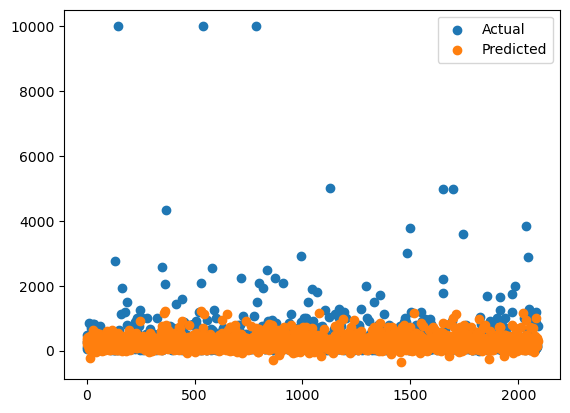

In [80]:
#Compare actual vs predicted values

plt.scatter(range(len(y_test)), y_test.price, label='Actual')
plt.scatter(range(len(y_predict)), y_predict.price, label='Predicted')
plt.legend()
plt.show()


In [81]:
## Advanced Tree Modelling 

#train_df=data_cleaning_and_processing(X_train)
#test_df=data_cleaning_and_processing(X_test)

model=xgb.XGBRegressor(n_estimators=200)
model.fit(train_df,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [82]:
y_predict=model.predict(test_df)
pd.DataFrame(y_predict)
r2_score(y_test,y_predict)

0.21052368427215584

In [83]:
# Calculate the loss values
#xgb_loss = model.get_booster().best_score


# Plot the loss functions

#plt.plot(train_df, xgb_loss, label='XGBoost Loss')
#plt.xlabel('X')
#plt.ylabel('Loss')
#plt.title('Loss Functions')
#plt.legend()
#plt.show()

In [84]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, r2_score

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.1, 0.05],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9, 1.0],
#     'gamma': [0, 1]
}

# Create an XGBoost regressor model
model = xgb.XGBRegressor()

# Create GridSearchCV object with r2 scoring
scoring = make_scorer(r2_score)
grid_search = GridSearchCV(model, param_grid, cv=2, scoring=scoring)

# Fit the GridSearchCV object to the training data
grid_search.fit(train_df, y_train)

# Print the best parameter combination and score
print("Best Parameters: ", grid_search.best_params_)
print("Best R-squared Score: ", grid_search.best_score_)

Best Parameters:  {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 100, 'subsample': 0.8}
Best R-squared Score:  0.1343079225682225


In [85]:
model = xgb.XGBRegressor(**grid_search.best_params_)
model.fit(train_df, y_train)

y_predict=model.predict(test_df)
r2_score(y_test,y_predict)

0.27985517148202865

In [86]:
## our accuracy has increased 

In [87]:
## Only using word features now in modelling

In [88]:
# Indexes change on test_train split so reset it because we have to loop below
train_df=data_cleaning_and_processing(X_train,'word').reset_index()
test_df=data_cleaning_and_processing(X_test,'word').reset_index()

                                                   name  minimum_nights  \
2924  Contempo Cottage - Secluded 3BR/2BA Urban Geta...               2   
6649                       Planet Budtron/High Tide Inn               1   
2524  Waterfront Bungalow on Lake Travis, pool & hot...               2   
8402  Luxury Lake Travis Villa with Hot Tub - Sleeps...               2   
5241                           Sunny Room near Downtown               2   
...                                                 ...             ...   
5736        Downtown/6th Historic Urban Loft 1,500sqft.               1   
5193  Evans: Central Austin Young Professional Commu...              29   
5392       Spacious, Fully Loaded Home in South Austin!              31   
861   The Littlefields by Lodgewell - Stylish Downto...               1   
7272              East Domain Bungalow ( Self Check-in)               2   

      number_of_reviews  calculated_host_listings_count  availability_365  \
2924                 9

In [89]:
train_df['name'][5]

"E. Austin Newly Reno'd House w/ Private Bathroom"

In [90]:

def review_to_words( raw_review ):
    # Function to convert a raw review to a string of words
    # The input is a single string , and 
    # the output is a single string 
    #
    # 1. Remove HTML
    review_text = BeautifulSoup(raw_review).get_text() 
   
    #
    # 2. Remove non-letters        
    letters_only = re.sub("[^a-zA-Z0-9]", "", review_text) 
    
    #
    # 3. Convert to lower case, split into individual words
    words = letters_only.lower().split() 
    #print(words)
    #
    # 4. In Python, searching a set is much faster than searching
    #   a list, so convert the stop words to a set
    stops = set(stopwords.words("english"))
    #print(stops)
    # 
    # 5. Remove stop words
    meaningful_words = [w for w in words if not w in stops]   
    #
    # 6. Join the words back into one string separated by space, 
    # and return the result.
    
    return( " ".join( meaningful_words ))   




# Get the number of reviews based on the dataframe column size
num_reviews = train_df["name"].size
num_reviews1 = test_df["name"].size
#len(train_df.name)


# Initialize an empty list to hold the clean reviews
train_corpus = []

for i in range( 0, num_reviews ):
    # If the index is evenly divisible by 1000, print a message
    if( (i+1)%1000 == 0 ):
        print ("Name %d of %d\n" % ( i+1, num_reviews )  )                                                                  
    train_corpus.append( review_to_words( train_df["name"][i] ))



test_corpus = []
for i in range( 0, num_reviews1 ):
     # If the index is evenly divisible by 1000, print a message
    if( (i+1)%1000 == 0 ):
         print ("Name %d of %d\n" % ( i+1, num_reviews1 )  )                                                                  
    test_corpus.append( review_to_words( test_df["name"][i] ))



    


Name 1000 of 8358

Name 2000 of 8358

Name 3000 of 8358

Name 4000 of 8358

Name 5000 of 8358

Name 6000 of 8358

Name 7000 of 8358

Name 8000 of 8358

Name 1000 of 2090

Name 2000 of 2090



In [91]:
tv = CountVectorizer(binary = False, ngram_range = (1,2), stop_words = 'english', max_features=600)


tv_df=tv.fit_transform(train_corpus)


test_df=tv.transform(test_corpus)


model=xgb.XGBRFRegressor(n_estimators=200).fit(tv_df,y_train)



y_predict=model.predict(test_df)
r2_score(y_test,y_predict)

-6.653012596169461e-06

In [92]:

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300,500],
    'learning_rate': [0.5 ,0.1, 0.05],
    'max_depth': [3, 4, 5, 8],
    'subsample': [0.8, 0.9, 1.0],
     'gamma': [0, 1,5]
}

# Create an XGBoost regressor model
model = xgb.XGBRegressor()

# Create GridSearchCV object with r2 scoring
scoring = make_scorer(r2_score)
grid_search = GridSearchCV(model, param_grid, cv=3, scoring=scoring)

# Fit the GridSearchCV object to the training data
grid_search.fit(tv_df, y_train)

# Print the best parameter combination and score
print("Best Parameters: ", grid_search.best_params_)
print("Best R-squared Score: ", grid_search.best_score_)

model = xgb.XGBRegressor(**grid_search.best_params_)
model.fit(tv_df, y_train)

y_predict=model.predict(test_df)
r2_score(y_test,y_predict)

Best Parameters:  {'gamma': 0, 'learning_rate': 0.5, 'max_depth': 8, 'n_estimators': 300, 'subsample': 0.8}
Best R-squared Score:  0.013351867537437334


0.006166367779845583

In [93]:
tv = TfidfVectorizer(binary = False, ngram_range = (1,2), stop_words = 'english', max_features=700)
tv_df=tv.fit_transform(train_corpus)
test_df=tv.transform(test_corpus)
model=xgb.XGBRFRegressor(n_estimators=200).fit(tv_df,y_train)
y_predict=model.predict(test_df)
r2_score(y_test,y_predict)

-6.5815650254208435e-06

In [94]:

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.1, 0.05],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9, 1.0],
     'gamma': [0, 1,5]
}

# Create an XGBoost regressor model
model = xgb.XGBRegressor()

# Create GridSearchCV object with r2 scoring
scoring = make_scorer(r2_score)
grid_search = GridSearchCV(model, param_grid, cv=2, scoring=scoring)

# Fit the GridSearchCV object to the training data
grid_search.fit(tv_df, y_train)

# Print the best parameter combination and score
print("Best Parameters: ", grid_search.best_params_)
print("Best R-squared Score: ", grid_search.best_score_)

Best Parameters:  {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.9}
Best R-squared Score:  0.0023663347799833256


In [95]:
model = xgb.XGBRegressor(**grid_search.best_params_)
model.fit(tv_df, y_train)

y_predict=model.predict(test_df)
r2_score(y_test,y_predict)

0.004756308181652846

In [96]:
## for students 

#1)## combine both word and numerical features and coming up with model could shoot up accuracy 
#2) ## meta model approach  (Stacking model )
#3)## word2vec or glove_embeddings()
